In [3]:
import matplotlib
import pickle
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import numpy as np
import pickle
from torch.optim import lr_scheduler
from os.path import exists
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchaudio import transforms
import torchvision.models as models
import random
torch.manual_seed(1)
random.seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [4]:
def process_pkl(pkl_data, pos=0):
    position = pkl_data[('mocap', 'mocap')]["gt_positions"][pos]
    node_data = []
    for i in range(1, 5):
        if len(pkl_data[('mic_waveform', f'node_{i}')]) < 1000:
            return None
        node_data.append(torch.tensor(pkl_data[('mic_waveform', f'node_{i}')][:, 1:5]))
    return position, torch.stack(node_data).permute(0, 2, 1)

def load_original_data(data_folder="truck"):
    if data_folder=="truck":
        train_filelist = glob.glob(r"original_data\truck1_data\train\*")
        val_filelist = glob.glob(r"original_data\truck1_data\val\*")
        test_filelist = glob.glob(r"original_data\truck1_data\test\*")
        
    else:
        train_filelist = glob.glob(r"original_data\bus_data\train\*")
        val_filelist = glob.glob(r"original_data\bus_data\val\*")
        test_filelist = glob.glob(r"original_data\bus_data\test\*")
    
    waveforms_list = []
    positions_list = []

    wrong_len_list = []

    for list_index, filelist in enumerate([train_filelist, val_filelist, test_filelist]):
        wrong_len = []
        positions= []
        waveforms = []
        for i, pkl_filename in enumerate(filelist):
            with open(pkl_filename, "rb") as f:
                pkl_data = pickle.load(f)
                if data_folder == "truck":
                    result = process_pkl(pkl_data)
                    if result is None:
                        wrong_len.append(i)
                        continue
                    position, waveform = result
                else:
                    result = process_pkl(pkl_data, pos=6)
                    if result is None:
                        wrong_len.append(i)
                        continue
                    position, waveform = result
                    position[0] = (position[0]+2162.78244)/10
                    position[1] = (position[1]+1637.84491)/10
                    position = position[:2]

                positions.append(position)
                waveforms.append(waveform)
        waveforms = torch.stack(waveforms)
        positions = torch.stack(positions)

        waveforms_list.append(waveforms)
        positions_list.append(positions)
        wrong_len_list.append(wrong_len)
        print("Original:", len(filelist), "Num Removed:", len(wrong_len))
    return waveforms_list, positions_list
waveform_splits, position_lists = load_original_data()
combined_waveforms = torch.cat([waveform.reshape(1, *waveform.shape) for waveform in waveform_splits], 1).squeeze()
combined_positions = torch.cat([position.reshape(1, *position.shape) for position in position_lists], 1).squeeze()
print(combined_waveforms.shape, combined_positions.shape)



Original: 2975 Num Removed: 107
Original: 595 Num Removed: 0
Original: 2380 Num Removed: 79
torch.Size([5764, 4, 4, 1056]) torch.Size([5764, 2])


In [5]:
# torch.save([combined_waveforms, combined_positions], "final_results/truck_final_combined_data.pt")
combined_waveforms, combined_positions= torch.load("final_results/truck_final_combined_data.pt")
print(combined_waveforms.shape, combined_positions.shape)
num_waveforms = combined_waveforms.shape[0]
print(num_waveforms)

torch.Size([5764, 4, 4, 1056]) torch.Size([5764, 2])
5764


# Data Processing

In [14]:
def calculate_rms(waveforms):
    reshape=False
    if len(waveforms.shape) == 4:
        waveforms = waveforms.reshape(-1, 16, 1056)
        reshape = True
    return waveforms.square().mean(axis=len(waveforms.shape) - 1).sqrt()

def get_max_rms(rms_waveforms):
    return rms_waveforms.max(axis=1)[0]
torch.manual_seed(1)
random.seed(1)
rms_waveforms = calculate_rms(combined_waveforms)
max_rms = get_max_rms(rms_waveforms)
sorted_max_indexes = max_rms.argsort(descending=True)
bin_size = len(sorted_max_indexes) // 10
# Print max rms from each bin
for i in range(1, 11): print(f"Bin {i} rms threshold from index {i*bin_size}", max_rms[sorted_max_indexes[i*bin_size]])
# Get the indexes for the bins and randomize them
bins = [sorted_max_indexes[i*bin_size:i*bin_size+bin_size][torch.randperm(bin_size)] for i in range(10)]

# Another randomize function
for i in range(10): bins[i] = bins[i][torch.randperm(len(bins[i]))]
print("Bin size", bin_size)
# For each bin take out the 0.8 to 1.0 section of the bins
test_set_bins = [bins[i][int(len(bins[i]) // 5 * 4):int(len(bins[i]) // 5 * 5)] for i in range(10)]

print("Test set bin size", test_set_bins[0].shape)
test_set_bins_stacked = [torch.hstack(test_set_bins[:i]) for i in range(1, 11)]
# for bin in test_set_bins_stacked:
#     print(len(bin))
threshold_cv_groups_list = []
for num_bins_used in range(1, 11):
    threshold_cv_groups = [[] for i in range(4)]
    for bin_index in range(num_bins_used):
        for group_num in range(4):
            threshold_cv_groups[group_num].extend(bins[bin_index][int(len(bins[i]) // 5 * group_num):int(len(bins[i]) // 5 * (group_num + 1))])
    threshold_cv_groups = [torch.tensor(group)[torch.randperm(len(group))] for group in threshold_cv_groups]
    threshold_cv_groups_list.append(threshold_cv_groups)
print("Num of thresholds", len(threshold_cv_groups_list))
for i in range(10): print(f"Threshold {i+1} size", len(threshold_cv_groups_list[i][0])*4)

# Code here to save the bins as they are used
bin_threshold = 7
print(len(threshold_cv_groups_list[0][0]))
print([len(i) for i in threshold_cv_groups_list[bin_threshold - 1]])
print(len(test_set_bins_stacked[bin_threshold - 1]))
torch.save([threshold_cv_groups_list[bin_threshold - 1], test_set_bins_stacked[bin_threshold - 1]], "final_results/truck_combined_data_indexes.pt")

Bin 1 rms threshold from index 576 tensor(0.0055)
Bin 2 rms threshold from index 1152 tensor(0.0050)
Bin 3 rms threshold from index 1728 tensor(0.0047)
Bin 4 rms threshold from index 2304 tensor(0.0044)
Bin 5 rms threshold from index 2880 tensor(0.0042)
Bin 6 rms threshold from index 3456 tensor(0.0040)
Bin 7 rms threshold from index 4032 tensor(0.0038)
Bin 8 rms threshold from index 4608 tensor(0.0033)
Bin 9 rms threshold from index 5184 tensor(0.0028)
Bin 10 rms threshold from index 5760 tensor(0.0021)
Bin size 576
Test set bin size torch.Size([115])
Num of thresholds 10
Threshold 1 size 460
Threshold 2 size 920
Threshold 3 size 1380
Threshold 4 size 1840
Threshold 5 size 2300
Threshold 6 size 2760
Threshold 7 size 3220
Threshold 8 size 3680
Threshold 9 size 4140
Threshold 10 size 4600
115
[805, 805, 805, 805]
805


# Data processing for RMS and Spectrogram training

In [9]:
def new_code():
    torch.manual_seed(1)
    random.seed(1)
    rms_waveforms = calculate_rms(combined_waveforms)
    max_rms = get_max_rms(rms_waveforms)
    sorted_max_indexes = max_rms.argsort(descending=True)
    bin_size = len(sorted_max_indexes) // 10
    # Print max rms from each bin
    for i in range(1, 11): print(f"Bin {i} rms threshold from index {i*bin_size}", max_rms[sorted_max_indexes[i*bin_size]])
    # Get the indexes for the bins
    bins = [sorted_max_indexes[i*bin_size:i*bin_size+bin_size] for i in range(10)]
    # Sort the contents of the bins so that when dividing up it is less likly nearby datapoints are in different sections
    for i in range(10): bins[i] = torch.sort(bins[i])[0]
    test_set_bins = [bins[i][int(len(bins[i]) // 5 * 4):int(len(bins[i]) // 5 * 5)] for i in range(10)]
    train_set_bins = [bins[i][0:int(len(bins[i]) // 5 * 4)] for i in range(10)]
    train_set_indexes_7_sorted = torch.sort(torch.hstack(train_set_bins[:7]))[0]
    print(train_set_indexes_7_sorted.shape)
    print(train_set_indexes_7_sorted[100:150])
    print(torch.min(get_max_rms(rms_waveforms[train_set_indexes_7_sorted])))
    torch.save(train_set_indexes_7_sorted, "final_results/train_set_indexes_7_sorted.pt")
    torch.save(test_set_bins, "final_results/test_set_bins.pt")
    print(460*7)
new_code()

Bin 1 rms threshold from index 576 tensor(0.0055)
Bin 2 rms threshold from index 1152 tensor(0.0050)
Bin 3 rms threshold from index 1728 tensor(0.0047)
Bin 4 rms threshold from index 2304 tensor(0.0044)
Bin 5 rms threshold from index 2880 tensor(0.0042)
Bin 6 rms threshold from index 3456 tensor(0.0040)
Bin 7 rms threshold from index 4032 tensor(0.0038)
Bin 8 rms threshold from index 4608 tensor(0.0033)
Bin 9 rms threshold from index 5184 tensor(0.0028)
Bin 10 rms threshold from index 5760 tensor(0.0021)
torch.Size([3220])
tensor([122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
        150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171])
tensor(0.0038)
3220


# Base Model Setup

In [48]:
class ScaledSigmoid(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(x) * torch.tensor([700, 500]).to(device)

def squared_loss(a, b):
    return (((a-b)**2)).sum(axis=1).mean()

def mae_loss(a, b):
    return (((a-b)**2)).sum(axis=1).sqrt().mean()

def spec(waveform, f=200, single_bin=False):
    if single_bin:
        transform = transforms.Spectrogram(n_fft=f, hop_length=waveform.shape[-1]+1)
    else:
        transform=transforms.Spectrogram(n_fft=f)
    result = transform(waveform.cpu()).cuda()
    return result
        

def train_model(data, tests=None, batch_size=32, epochs=100, parameters="", saving="",
                shuffle_data=True, save=False, verbose=True, 
                validation_losses=None, train_losses = None, sch=[(0.001, 100)]):
    
    X_train, Y_train, X_val, Y_val = data
    X_train = spec(X_train)
    X_val = spec(X_val)
    
    model = nn.Sequential(
        nn.LayerNorm((16, 101, 11)),
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.LayerNorm((8, 49, 4)),
        nn.Conv2d(in_channels=8, out_channels=4, kernel_size=2, stride=1),
        nn.Flatten(),
        nn.ReLU(),
        nn.LazyLinear(2),
        ScaledSigmoid()
    ).cuda()
    
    
    print(torch.min(Y_train[:, 0]), torch.max(Y_train[:, 0]), torch.min(Y_train[:, 1]), torch.max(Y_train[:, 1]))
    if validation_losses is None:
        validation_losses = []
        train_losses = []
    print(sch)
    parameters = f"models_5/b{batch_size},e{epochs},SCH{sch},{hash(str(model)) + hash(data)}" + parameters
    if saving == "delete":
        os.remove(parameters + "_model.pt")
        os.remove(parameters + "_loss.pt")
        return
    if exists(parameters + "_loss.pt") and saving=="use_saved":
        model.load_state_dict(torch.load(parameters + "_model.pt"))
        train_losses, validation_losses = torch.load(parameters + "_loss.pt")
        min_loss_epoch = torch.tensor(validation_losses).argmin().item()
        test_loss = squared_loss(model(X_test), Y_test)
        print("Using saved model", str(sch), str(int(train_losses[min_loss_epoch])).ljust(8), str(int(validation_losses[min_loss_epoch])).ljust(8), str(int(test_loss)).ljust(8))
        return model, train_losses, validation_losses, parameters[7:], test_loss
    else:
        print(parameters)
        
    if shuffle_data:
        perm=torch.randperm(len(X_train))
        X_train, Y_train = X_train[perm], Y_train[perm]

    optimizer = optim.Adam(params=model.parameters(), lr=1.0)
    lowest_valid_loss = torch.tensor(10000000)
    epochs = 0
    lr_change_epochs = []
    for lr, epoch_num in sch:
        lr_change_epochs.append(epochs)
        epochs += epoch_num
    pbar = tqdm(range(epochs), ncols=125)
    num_times_saved=0
    loss = nn.MSELoss()
    for epoch in pbar:
        if epoch in lr_change_epochs:
            new_lr = sch[lr_change_epochs.index(epoch)][0]
            for g in optimizer.param_groups:
                g['lr'] = new_lr
        for batch in range(len(X_train) // batch_size):
            model.train()
            optimizer.zero_grad()
            outputs_train = model(X_train[batch_size * batch: batch_size * (batch + 1)])
            
            batch_train_loss = loss(outputs_train, Y_train[batch_size * batch: batch_size * (batch + 1)])
            batch_train_loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            train_loss = mae_loss(model(X_train), Y_train)
            validation_loss = mae_loss(model(X_val), Y_val)
            
        if validation_loss < lowest_valid_loss:
            lowest_train_loss = train_loss
            lowest_valid_loss = validation_loss
            if "sav" in saving:
                torch.save(model.state_dict(), parameters + "_model.pt")
                num_times_saved += 1
            torch.save(model.state_dict(), "temp_model4.pt")
        validation_losses.append(validation_loss.detach().cpu().item())
        train_losses.append(train_loss.detach().cpu().item())
        pbar.set_description(str(epoch) +" Tr:"+ str(round(train_loss.item(), 2))+" V:"+ str(round(validation_loss.item(), 2)) + " "+str(num_times_saved) + " "+str(round(lowest_valid_loss.item(), 4)) + " "+str(new_lr))
    if "sav" in saving:
        torch.save((train_losses, validation_losses), parameters + "_loss.pt")
    model.load_state_dict(torch.load("temp_model4.pt"))
    if tests is not None:
        test_losses = []
        with torch.no_grad():
            X_tests, Y_tests = tests
            X_tests = [spec(X_test) for X_test in X_tests]
            for i in range(len(X_tests)):
                X_test = X_tests[i]
                Y_test = Y_tests[i]
                test_loss = mae_loss(model(X_test), Y_test)
                test_losses.append(test_loss)
    return model, train_losses, validation_losses, parameters[7:], test_losses, lowest_valid_loss, lowest_train_loss

def plot(results, title="Plot of Train and Validation Loss, "):
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot(results[1], label="Train Loss")
    plt.plot(results[2], label="Validation Loss")
    param = results[3]
    plt.title(title + param)
    plt.legend()
    plt.show()
    
def abs_loss(a, b):
    return (a-b).abs().mean()
    
def lstsq_model(data, tests=None):
    X_train, Y_train, X_val, Y_val = data
    node_positions = torch.tensor([[610, 199], [233, 13], [13, 117], [491, 393]]).cuda()
    
    Y_train_distances = torch.vstack([(node_position - Y_train).square().sum(axis=1).sqrt() for node_position in node_positions])
    Y_val_distances = torch.vstack([(node_position - Y_val).square().sum(axis=1).sqrt() for node_position in node_positions])
    
    X_train_rms = calculate_rms(X_train).reshape(-1, 4, 4).permute(1, 2, 0).reshape(4, -1)
    X_val_rms = calculate_rms(X_val).reshape(-1, 4, 4).permute(1, 2, 0).reshape(4, -1)
    
    average_train_loss = torch.tensor(0.0).cuda()
    average_valid_loss = torch.tensor(0.0).cuda()
    
    for i in range(4):
        A = torch.hstack([X_train_rms[i].reshape(-1, 1), torch.ones(len(X_train_rms[i])).reshape(-1, 1).cuda()])
        B = torch.hstack([Y_train_distances[i], Y_train_distances[i], Y_train_distances[i], Y_train_distances[i]])
        # print(A.shape, B.shape)
        m, b = torch.linalg.lstsq(A, B).solution
        # print((X_train_rms[i] * m + b).shape, B.shape)
        # print(X_train_rms[i] * m + b, B)
        train_loss = abs_loss(X_train_rms[i] * m + b, B)
        valid_loss = abs_loss(X_val_rms[i] * m + b, torch.hstack([Y_val_distances[i] for r in range(4)]))
        # print(i, train_loss, valid_loss)
        average_train_loss += train_loss / 4.0
        average_valid_loss += valid_loss / 4.0
    return average_train_loss, average_valid_loss

# Running Tests

In [50]:
# Running tests
train_results = []
valid_results = []
test_results = []

for theshold_cv_group_index, threshold_cv_group in enumerate(threshold_cv_groups_list):
    print(f"Top {theshold_cv_group_index+1}0% Results")
    total_train_loss = 0.0
    total_valid_loss = 0.0
    test_result = torch.zeros(20)
    
    if theshold_cv_group_index + 1 == 7:
        final_train = torch.hstack([group for group in threshold_cv_group])
        final_X_train = combined_waveforms[final_train].cuda().reshape(-1, 16, 1056)
        final_Y_train = combined_positions[final_train].cuda()
        final_X_test_lists = []
        final_Y_test_lists = []

        for test_set in test_set_bins: final_X_test_lists.append(combined_waveforms[test_set].cuda().reshape(-1, 16, 1056))
        for test_set in test_set_bins: final_Y_test_lists.append(combined_positions[test_set].cuda())
        final_X_test = torch.cat(final_X_test_lists)
        final_Y_test = torch.cat(final_Y_test_lists)
        
    for valid in threshold_cv_group:
        torch.manual_seed(1)
        random.seed(1)
        train = torch.hstack([group for group in threshold_cv_group if group is not valid])
        print(train.shape, valid.shape)
        X_train = combined_waveforms[train].cuda().reshape(-1, 16, 1056)
        Y_train = combined_positions[train].cuda()
        X_valid = combined_waveforms[valid].cuda().reshape(-1, 16, 1056)
        Y_valid = combined_positions[valid].cuda()
        
        test_X = []
        test_Y = []
        for test_set in test_set_bins: test_X.append(combined_waveforms[test_set].cuda().reshape(-1, 16, 1056))
        for test_set in test_set_bins: test_Y.append(combined_positions[test_set].cuda())
        
        for test_set in test_set_bins_stacked: test_X.append(combined_waveforms[test_set].cuda().reshape(-1, 16, 1056))
        for test_set in test_set_bins_stacked: test_Y.append(combined_positions[test_set].cuda())
        
        # Code for doing the least squares work
        results = lstsq_model((X_train, Y_train, X_valid, Y_valid))
        # print("Shapes", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
        curr_train_loss, curr_valid_loss = results
        # print("in progress", curr_train_loss, curr_valid_loss)
        total_train_loss += curr_train_loss
        total_valid_loss += curr_valid_loss

    train_results.append(total_train_loss.cpu().item()/4.0)
    valid_results.append(total_valid_loss.cpu().item()/4.0)
    test_results.append(test_result)
    print("train_loss", total_train_loss.cpu().item()/4.0, "validation_loss", total_valid_loss.cpu().item()/4.0)

Top 10% Results
torch.Size([345]) torch.Size([115])
torch.Size([345]) torch.Size([115])
torch.Size([345]) torch.Size([115])
torch.Size([345]) torch.Size([115])
train_loss 92.7983169555664 validation_loss 94.89497375488281
Top 20% Results
torch.Size([690]) torch.Size([230])
torch.Size([690]) torch.Size([230])
torch.Size([690]) torch.Size([230])
torch.Size([690]) torch.Size([230])
train_loss 86.63555145263672 validation_loss 87.45382690429688
Top 30% Results
torch.Size([1035]) torch.Size([345])
torch.Size([1035]) torch.Size([345])
torch.Size([1035]) torch.Size([345])
torch.Size([1035]) torch.Size([345])
train_loss 84.57144165039062 validation_loss 85.09097290039062
Top 40% Results
torch.Size([1380]) torch.Size([460])
torch.Size([1380]) torch.Size([460])
torch.Size([1380]) torch.Size([460])
torch.Size([1380]) torch.Size([460])
train_loss 83.85971069335938 validation_loss 84.22711181640625
Top 50% Results
torch.Size([1725]) torch.Size([575])
torch.Size([1725]) torch.Size([575])
torch.Size(

# Final_Results

10
-2.0966567993164062
[92.7983169555664, 86.63555145263672, 84.57144165039062, 83.85971069335938, 82.30740356445312, 81.94509887695312, 81.84780883789062, 84.73797607421875, 91.66586303710938, 98.1405258178711]


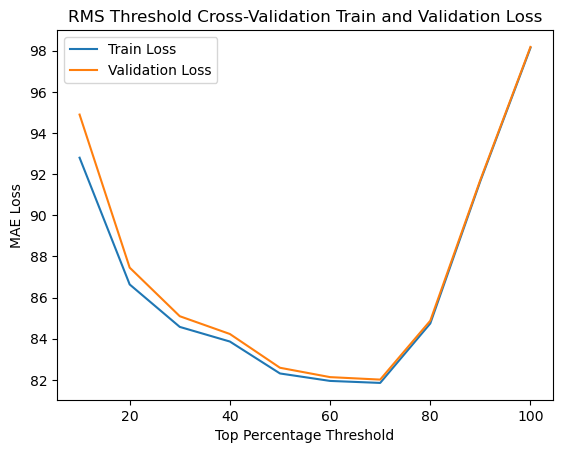

In [51]:
print(len(train_results))
torch.save([train_results, valid_results, test_results], "final_results/rms_thresholding1")
train_results, valid_results, test_results = torch.load("final_results/rms_thresholding1")
print(train_results[0]-valid_results[0])
print(train_results)
plt.plot([i*10 for i in range(1, 11)], train_results, label="Train Loss")
plt.title("RMS Threshold Cross-Validation Train and Validation Loss")
plt.xlabel("Top Percentage Threshold")
plt.ylabel("MAE Loss")

plt.plot([i*10 for i in range(1, 11)], valid_results, label="Validation Loss")
plt.legend()
plt.show()


torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([115, 2])
torch.Size([3220, 16, 1056]) torch.Size([3220, 2])
torch.Size([115, 16, 1056]) 40
10
torch.Size([3220, 16, 1056]) torch.Size([3220, 2]) torch.Size([115, 16, 1056]) torch.Size([115, 2])
(tensor(81.8535, device='cuda:0'), tensor(100.1537, device='cuda:0'))
20
torch.Size([3220, 16, 1056]) torch.Size([3220, 2]) torch.Size([115, 16, 1056]) torch.Size([115, 2])
(tensor(81.8535, device='cuda:0'), tensor(81.6805, device='cuda:0'))
30
torch.Size([3220, 16, 1056]) torch.Size([3220, 2]) torch.Size([115, 16, 1056]) torch.Size([115, 2])
(tensor(81.8535, device='cuda:0'), tensor(74.7910, device='cuda:0'))
40
torch.Size([3220, 16, 1056]) torch.Size([3220, 2]) torch.Size([115, 16, 1056]) torch.Size([115, 2])
(tensor(81.8535, device='cuda:0'), tensor(78.7689, device='cuda:0'))
50
torch.Size([3220

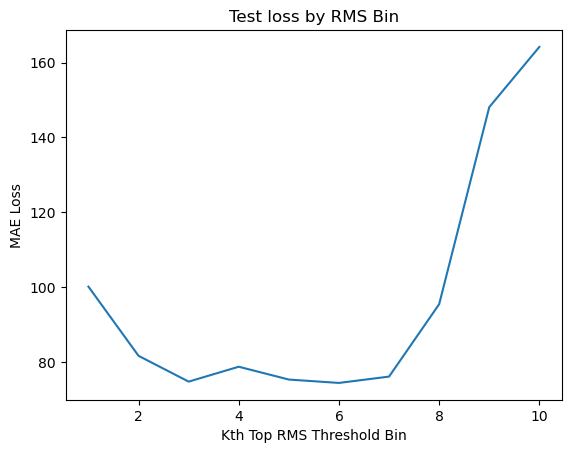

In [54]:
# Train on train and valid dataset. 
# Show the MAE on each of the individual test bins and report the average (mean MAE over all of them)

for test_set in test_set_bins:
    final_X_test_lists.append(combined_waveforms[test_set].cuda().reshape(-1, 16, 1056))
for test_set in test_set_bins:
    print(combined_positions[test_set].shape)
    final_Y_test_lists.append(combined_positions[test_set].cuda())
final_X_test = torch.cat(final_X_test_lists)
final_Y_test = torch.cat(final_Y_test_lists)


print(final_X_train.shape, final_Y_train.shape)
print(final_X_test_lists[0].shape, len(final_X_test_lists))
# Shapes torch.Size([345, 16, 1056]) torch.Size([345, 2]) torch.Size([115, 16, 1056]) torch.Size([115, 2])

test_loss_results = []
for i in range(10):
    print((i+1) * 10)
    print(final_X_train.shape, final_Y_train.shape, final_X_test_lists[i].shape, final_Y_test_lists[i].shape)
    results = lstsq_model((final_X_train, final_Y_train, final_X_test_lists[i], final_Y_test_lists[i]))
    curr_train_loss, curr_valid_loss = results
    test_loss_results.append(curr_valid_loss.cpu())
    print(results)
print("Final Training loss", curr_train_loss)
print("final test losses", [(i+1, loss) for i, loss in enumerate(test_loss_results)])
plt.plot([i for i in range(1, 11)], test_loss_results)
plt.xlabel("Kth Top RMS Threshold Bin")
plt.ylabel("MAE Loss")
plt.title("Test loss by RMS Bin")
plt.show()

tensor(42.8013) [tensor(54.9759), tensor(50.7305), tensor(45.2596), tensor(44.4966), tensor(45.6937), tensor(45.8254), tensor(42.8013), tensor(43.8372), tensor(45.9957), tensor(46.4839)]


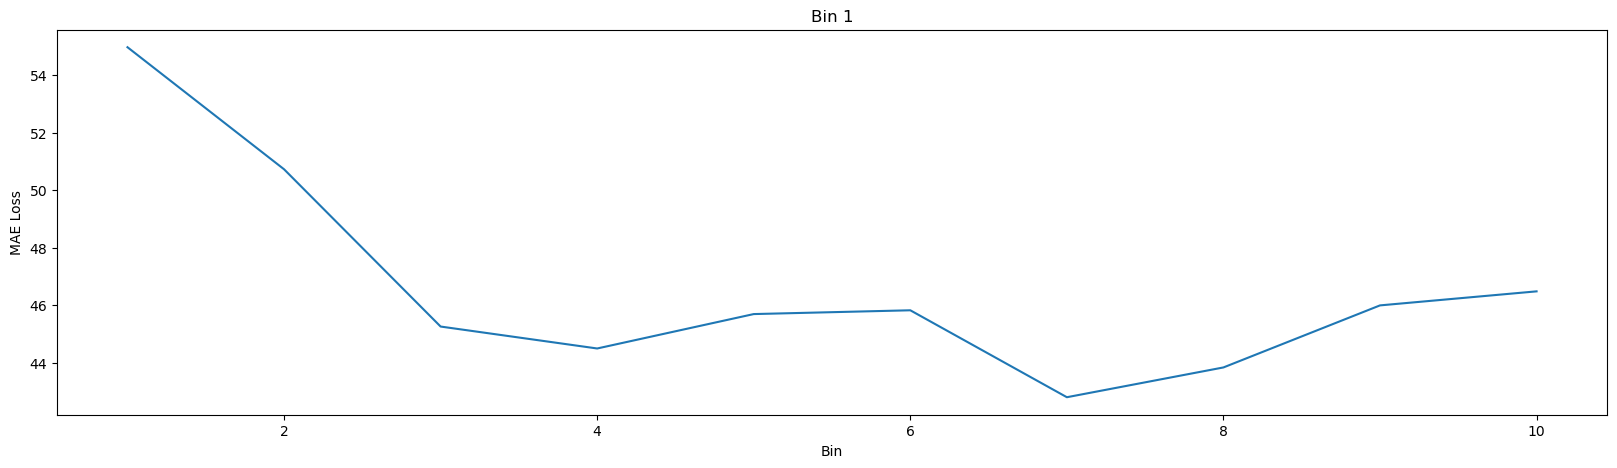

tensor(45.9282) [tensor(68.8563), tensor(53.5102), tensor(46.8779), tensor(49.7285), tensor(45.9282), tensor(45.9978), tensor(46.0935), tensor(47.8711), tensor(49.4112), tensor(49.7790)]


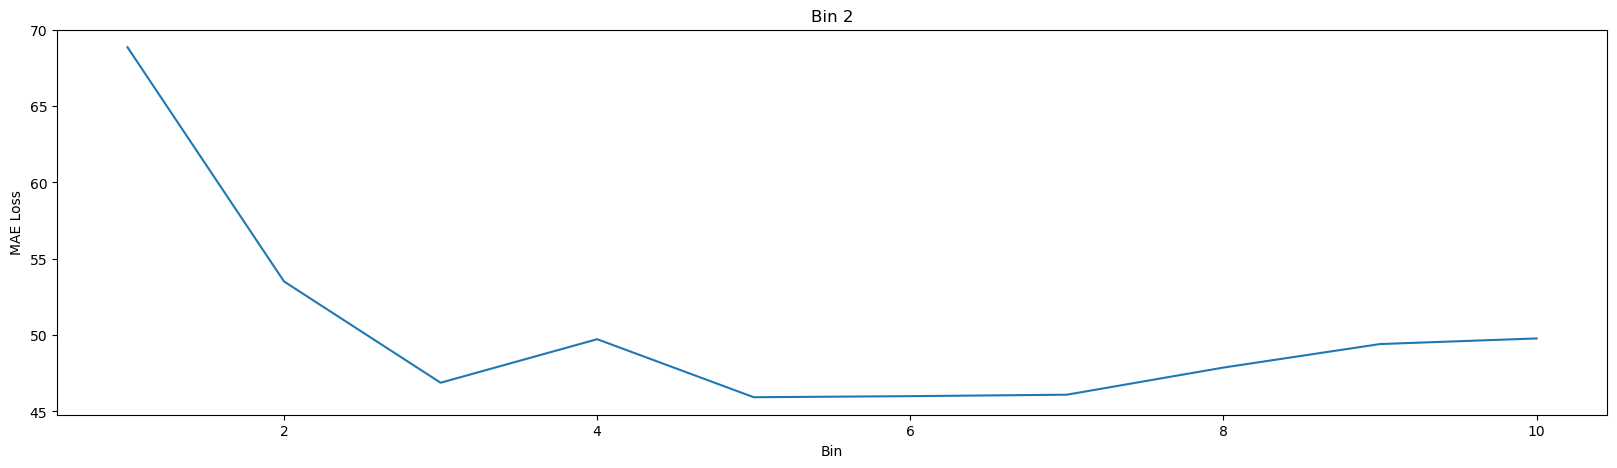

tensor(41.7129) [tensor(65.3613), tensor(54.0422), tensor(48.4285), tensor(43.9741), tensor(42.9235), tensor(42.7303), tensor(41.9410), tensor(41.7129), tensor(43.1916), tensor(43.9672)]


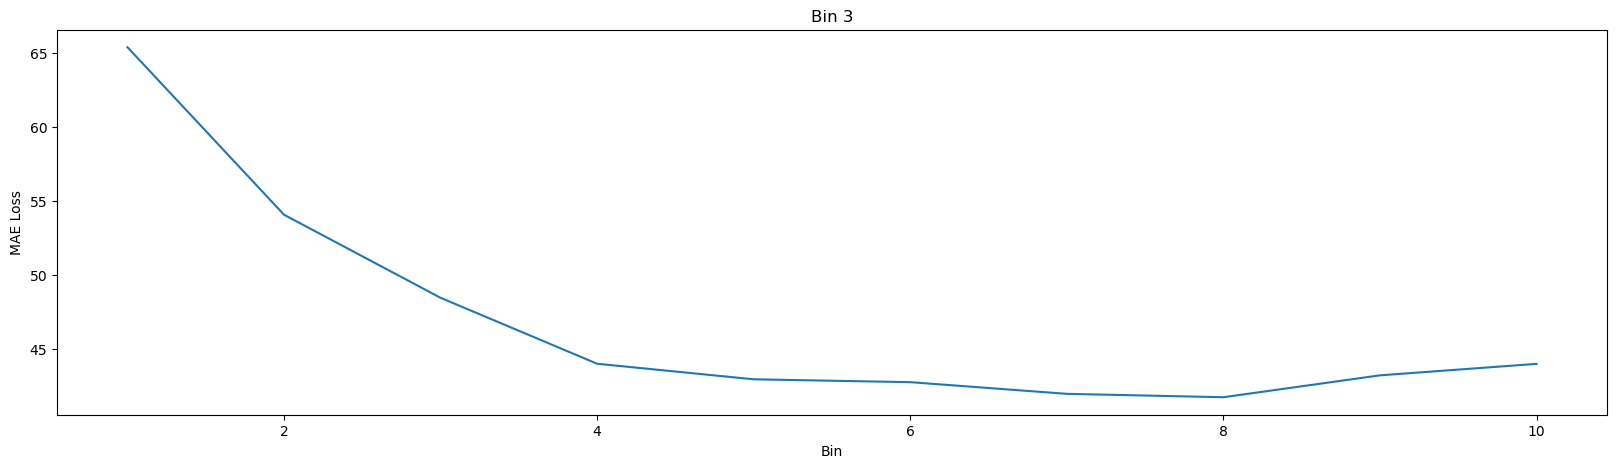

tensor(40.9561) [tensor(68.8912), tensor(57.4336), tensor(50.8419), tensor(43.9850), tensor(45.1247), tensor(43.4835), tensor(41.3585), tensor(40.9561), tensor(43.1015), tensor(46.9745)]


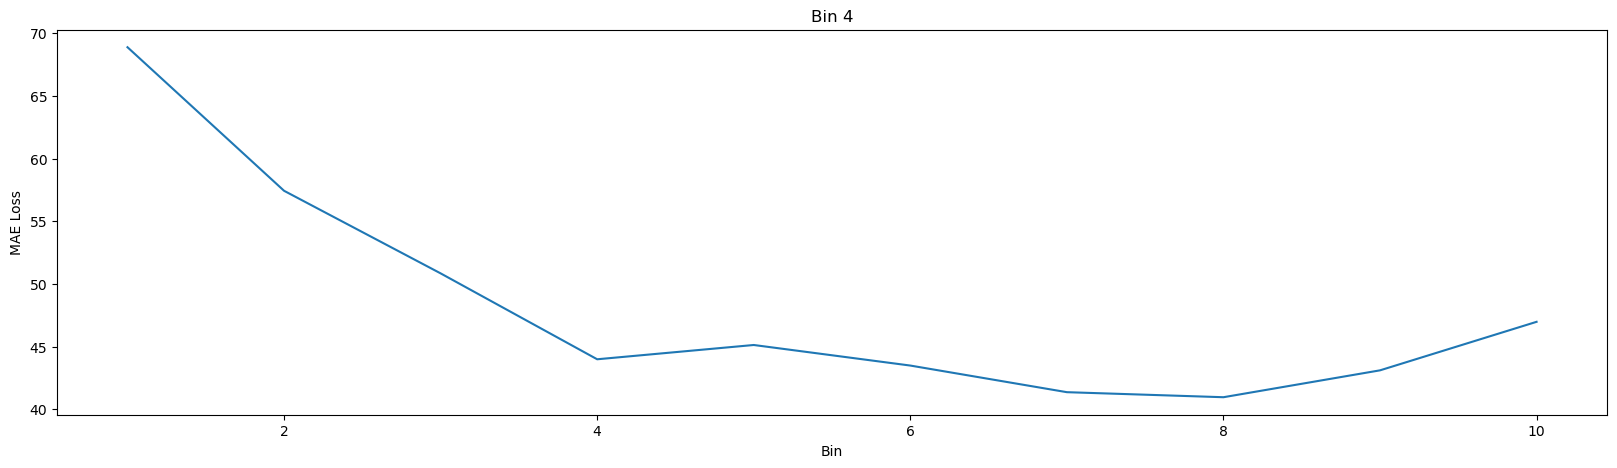

tensor(38.3118) [tensor(73.1242), tensor(56.5753), tensor(51.3861), tensor(47.6215), tensor(42.3213), tensor(40.7912), tensor(39.5359), tensor(38.3118), tensor(43.3950), tensor(44.4655)]


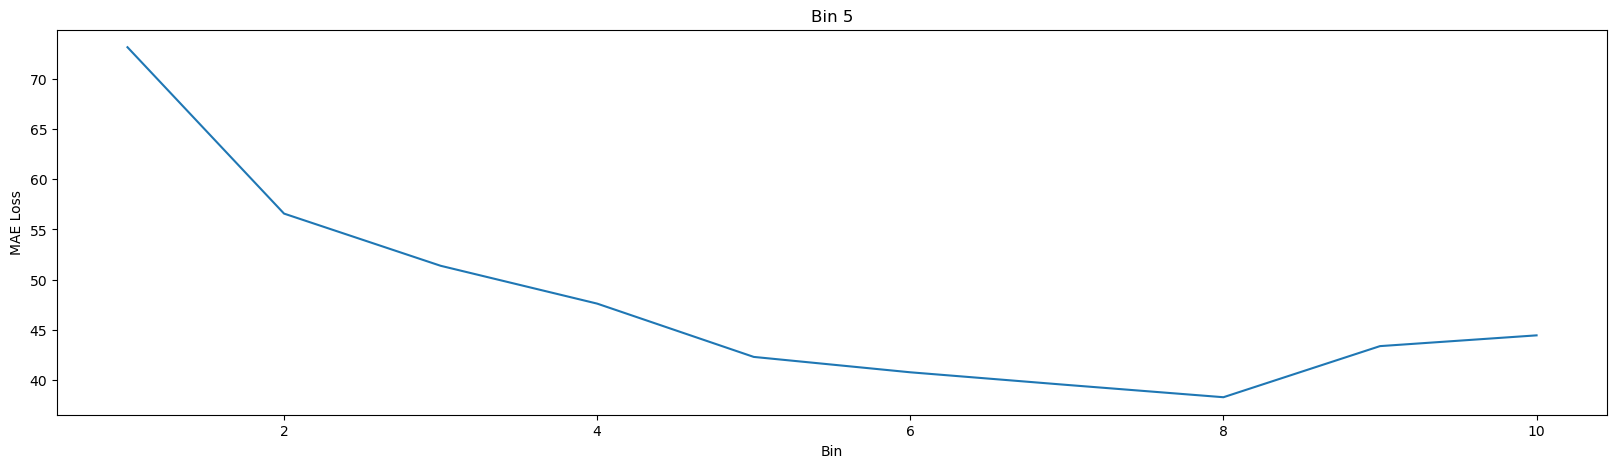

tensor(42.3068) [tensor(80.7384), tensor(67.1101), tensor(57.6624), tensor(53.5742), tensor(48.2793), tensor(46.5147), tensor(43.8942), tensor(42.3068), tensor(48.8946), tensor(47.5845)]


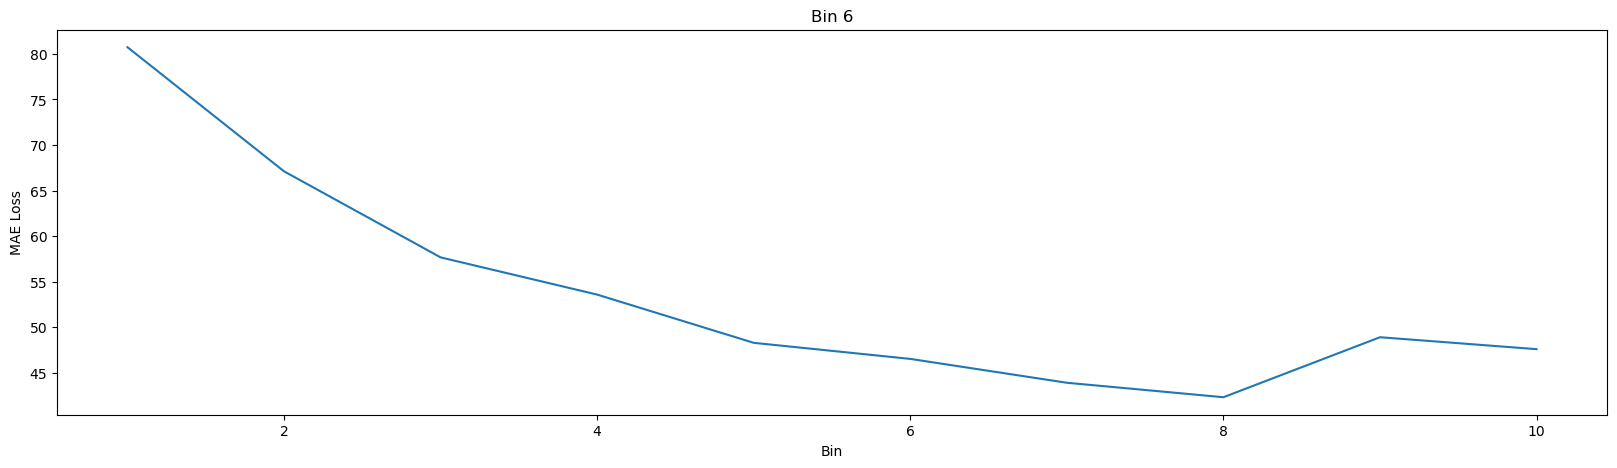

tensor(40.9109) [tensor(86.4808), tensor(69.6023), tensor(63.6185), tensor(56.2257), tensor(52.8891), tensor(47.1351), tensor(43.9683), tensor(42.2917), tensor(40.9109), tensor(43.0552)]


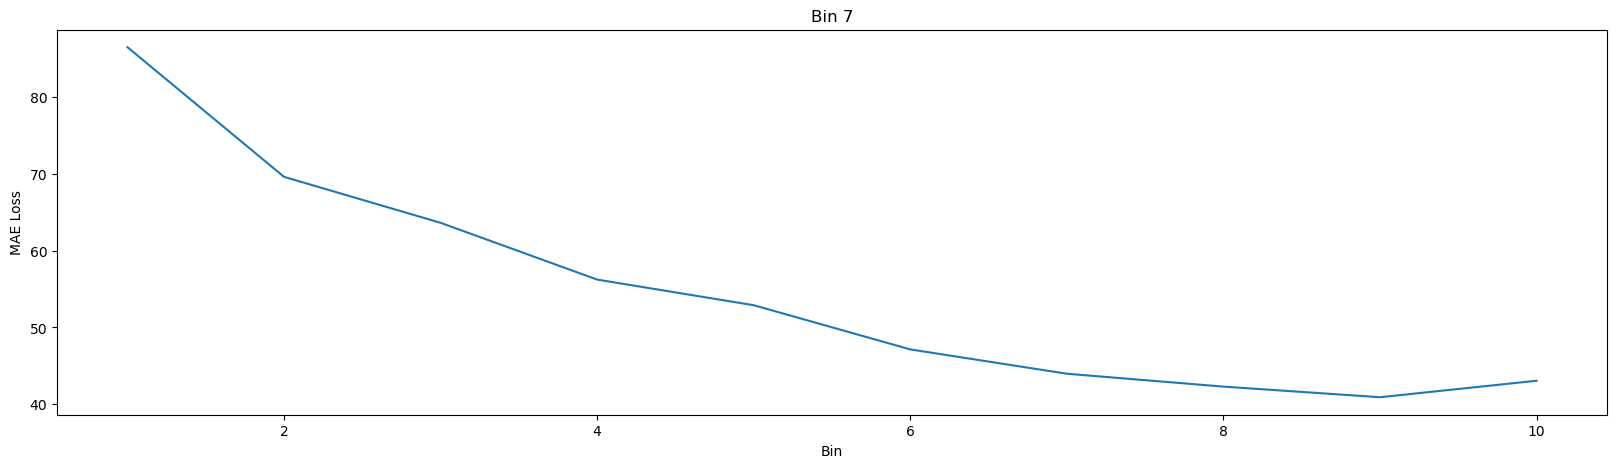

tensor(57.4856) [tensor(102.7506), tensor(83.6224), tensor(81.8337), tensor(73.4518), tensor(69.3687), tensor(67.6053), tensor(62.9146), tensor(57.4856), tensor(58.0997), tensor(59.1738)]


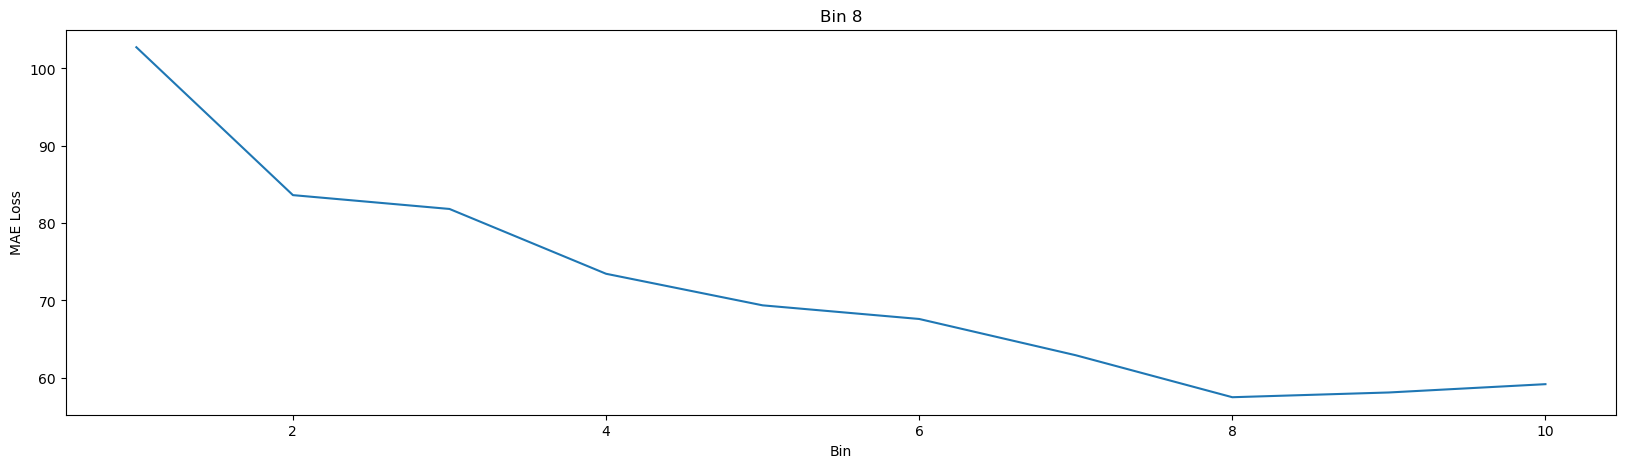

tensor(84.2519) [tensor(152.6324), tensor(137.0566), tensor(141.2479), tensor(139.3729), tensor(139.0703), tensor(136.7021), tensor(128.9429), tensor(106.6592), tensor(91.6351), tensor(84.2519)]


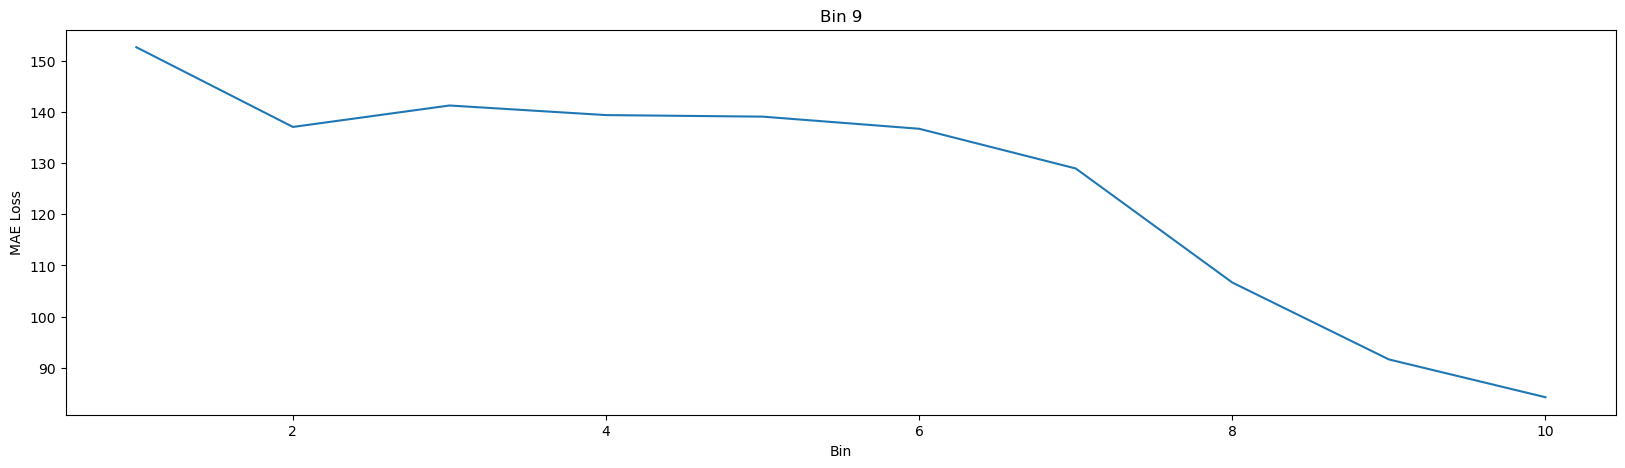

tensor(112.4645) [tensor(177.4576), tensor(162.0308), tensor(163.0568), tensor(161.4721), tensor(160.3400), tensor(156.7749), tensor(157.2882), tensor(134.7944), tensor(123.3320), tensor(112.4645)]


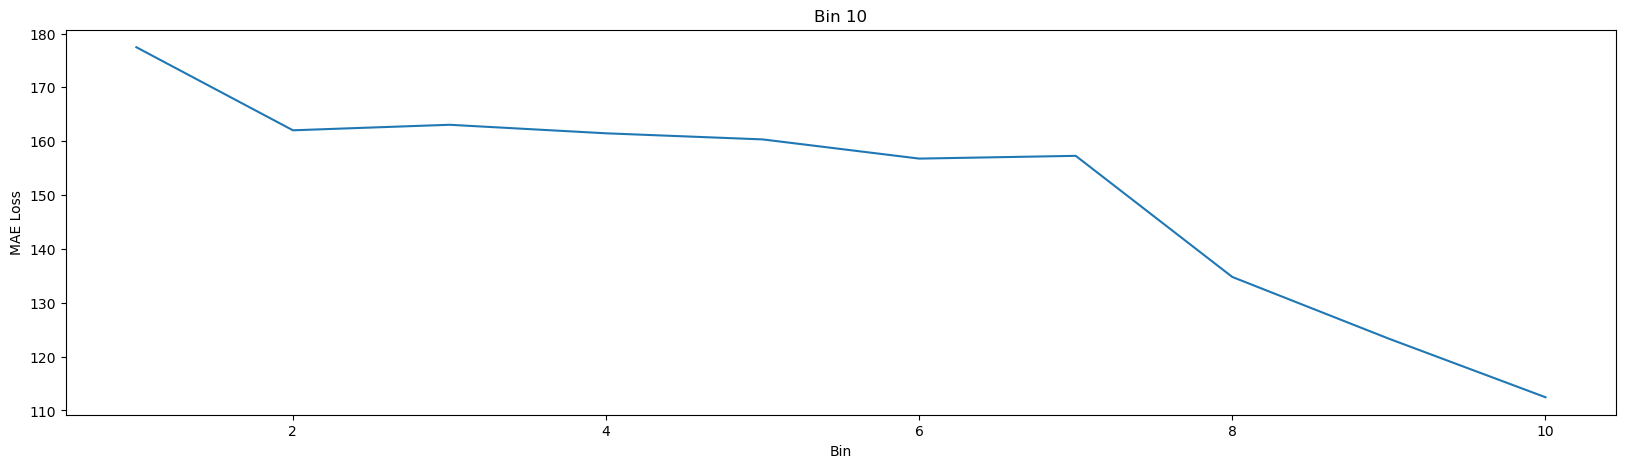

tensor(44.1163) [tensor(54.2847), tensor(46.7916), tensor(47.0962), tensor(46.4626), tensor(44.6314), tensor(45.1290), tensor(44.1163), tensor(45.3264), tensor(44.9444), tensor(46.6435)]


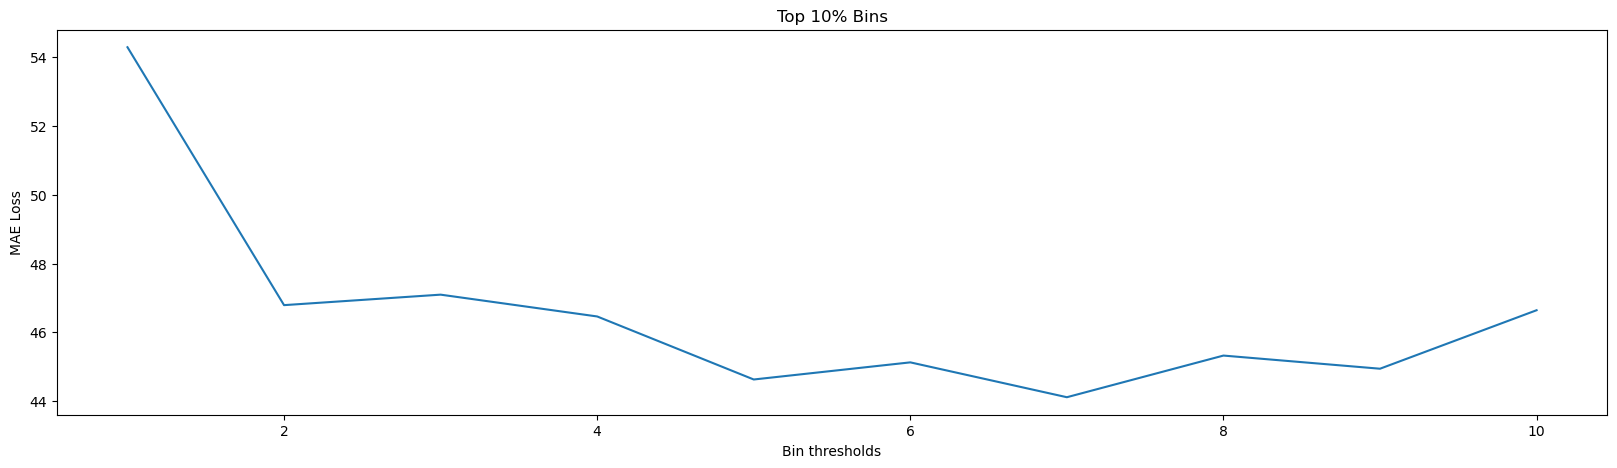

tensor(43.6424) [tensor(62.2539), tensor(49.9871), tensor(46.9721), tensor(47.4157), tensor(44.7479), tensor(44.8770), tensor(43.6424), tensor(47.1669), tensor(47.0588), tensor(48.8159)]


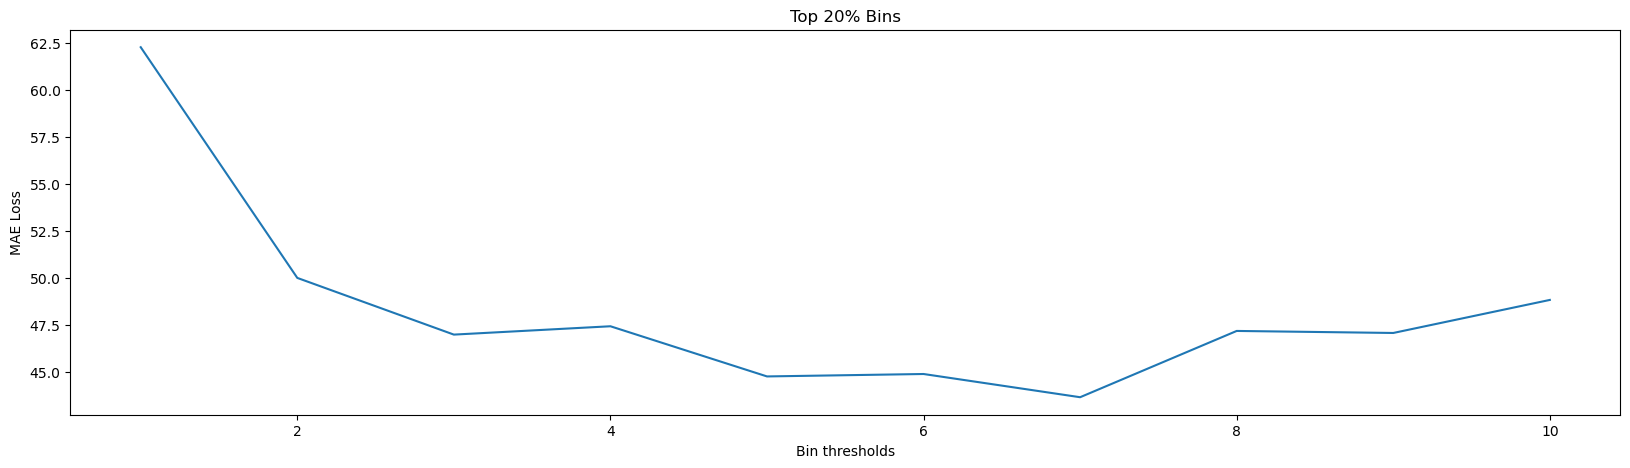

tensor(43.4363) [tensor(64.8845), tensor(51.7663), tensor(48.3673), tensor(46.5964), tensor(44.5590), tensor(45.7511), tensor(44.2064), tensor(43.4363), tensor(46.6436), tensor(46.9306)]


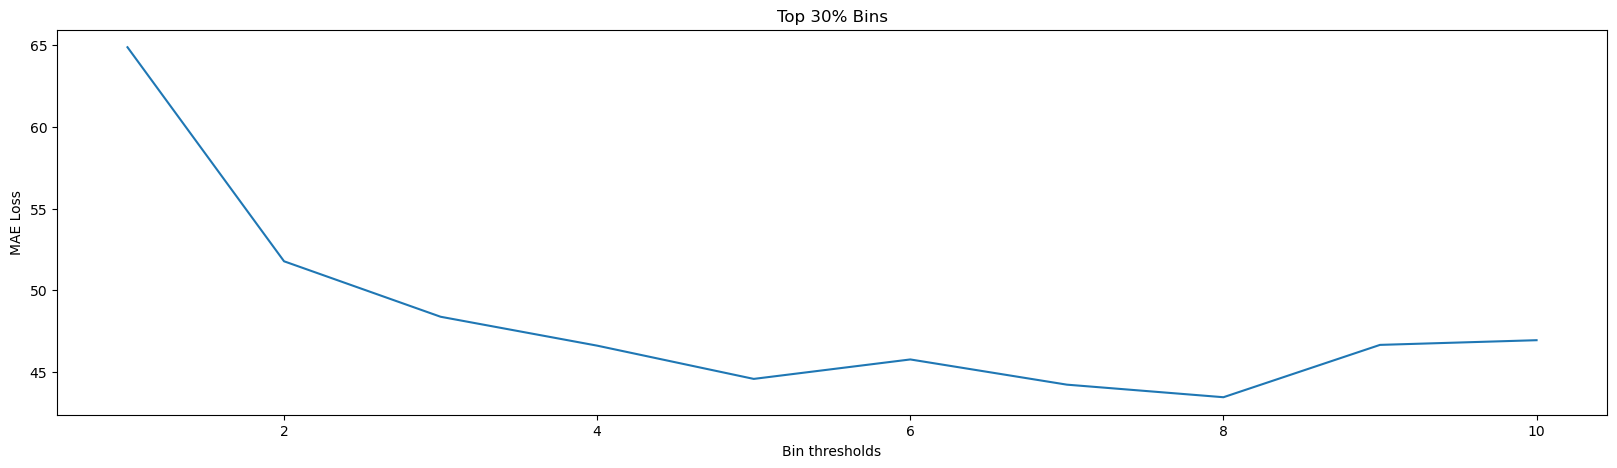

tensor(43.3991) [tensor(64.2398), tensor(53.2076), tensor(47.7218), tensor(46.1947), tensor(44.9053), tensor(44.2479), tensor(43.9805), tensor(43.3991), tensor(44.0811), tensor(46.9362)]


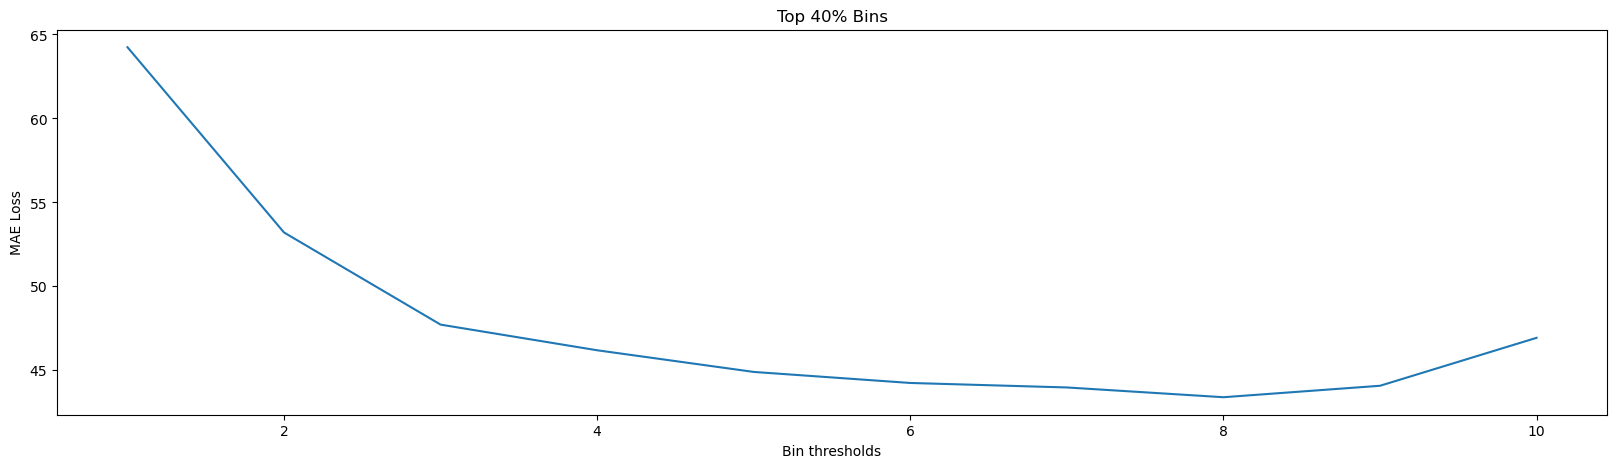

tensor(41.4347) [tensor(66.2641), tensor(54.6408), tensor(49.6808), tensor(46.5433), tensor(44.1367), tensor(42.6653), tensor(41.9845), tensor(41.4347), tensor(45.0322), tensor(46.3383)]


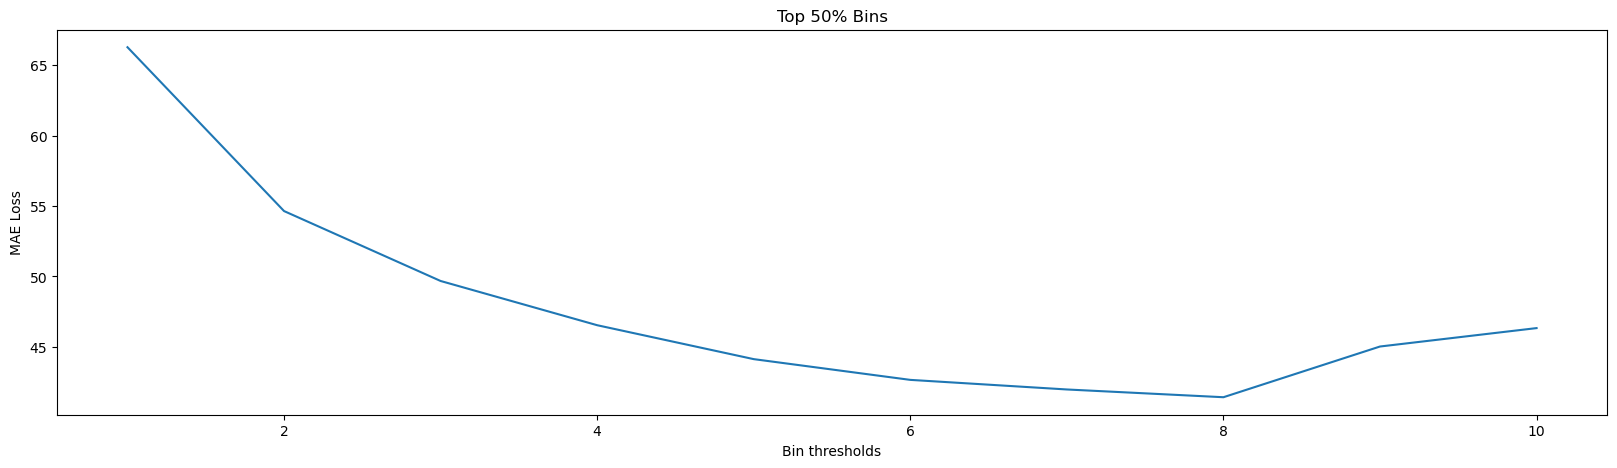

tensor(42.3194) [tensor(67.4437), tensor(55.4256), tensor(50.3298), tensor(47.5304), tensor(44.0306), tensor(42.6718), tensor(44.0594), tensor(42.3194), tensor(45.0164), tensor(47.2884)]


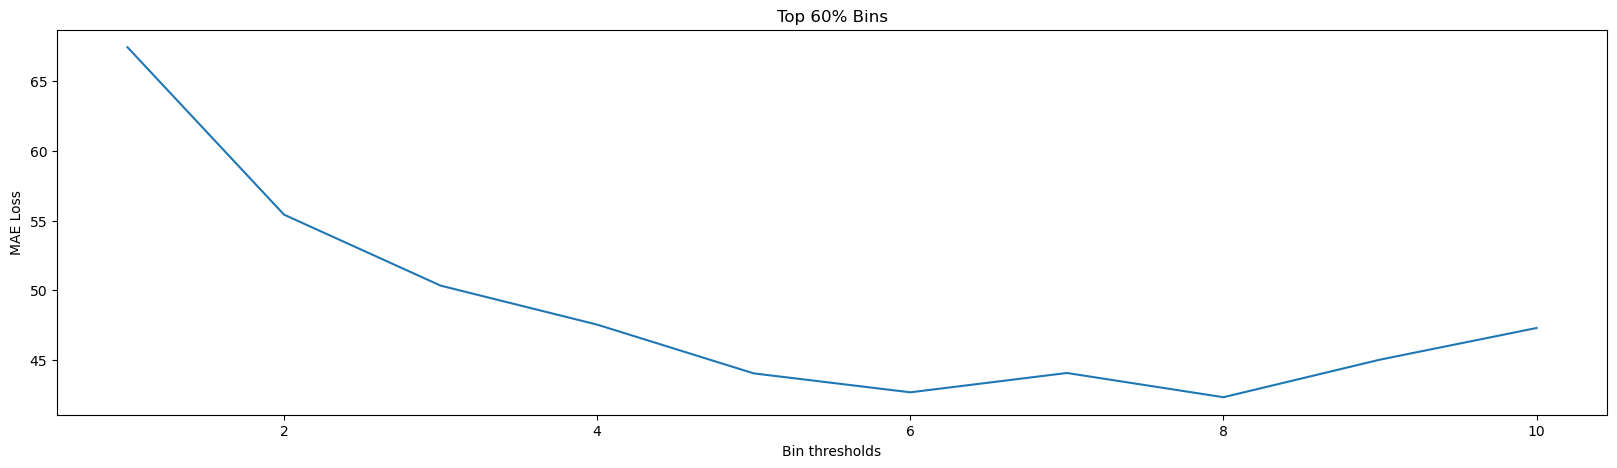

tensor(42.1494) [tensor(71.6192), tensor(58.0692), tensor(53.0799), tensor(48.9321), tensor(45.0699), tensor(43.2226), tensor(42.1494), tensor(43.6260), tensor(44.4661), tensor(46.5557)]


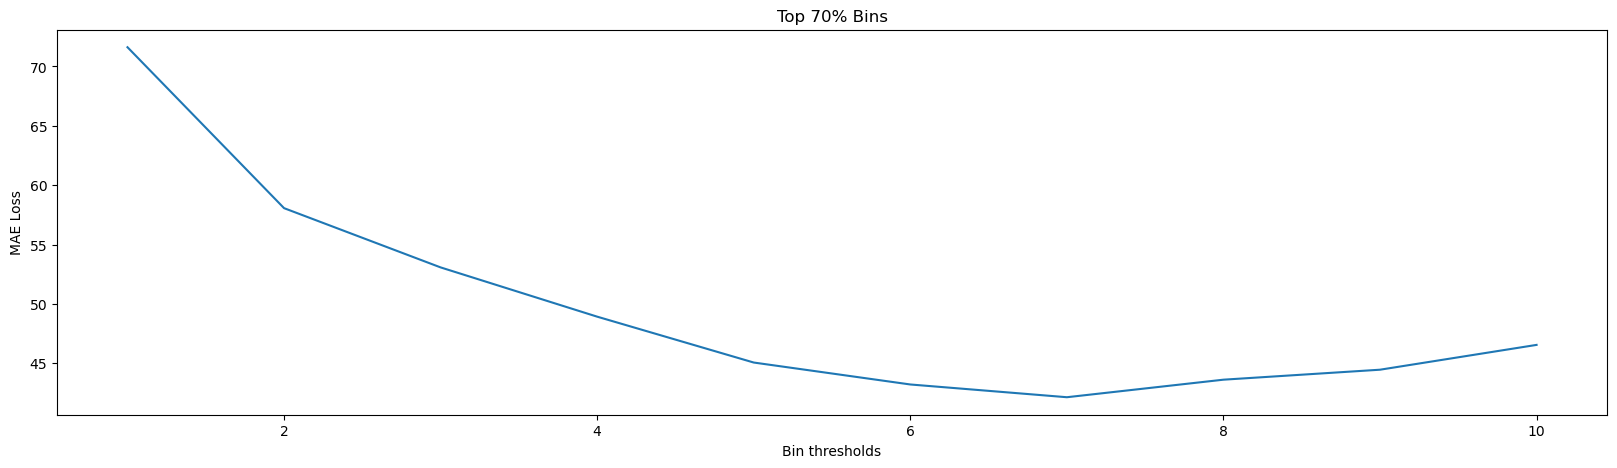

tensor(44.7351) [tensor(75.3813), tensor(61.2824), tensor(55.6477), tensor(52.2031), tensor(48.6665), tensor(46.6656), tensor(45.7697), tensor(44.7351), tensor(46.2662), tensor(48.5286)]


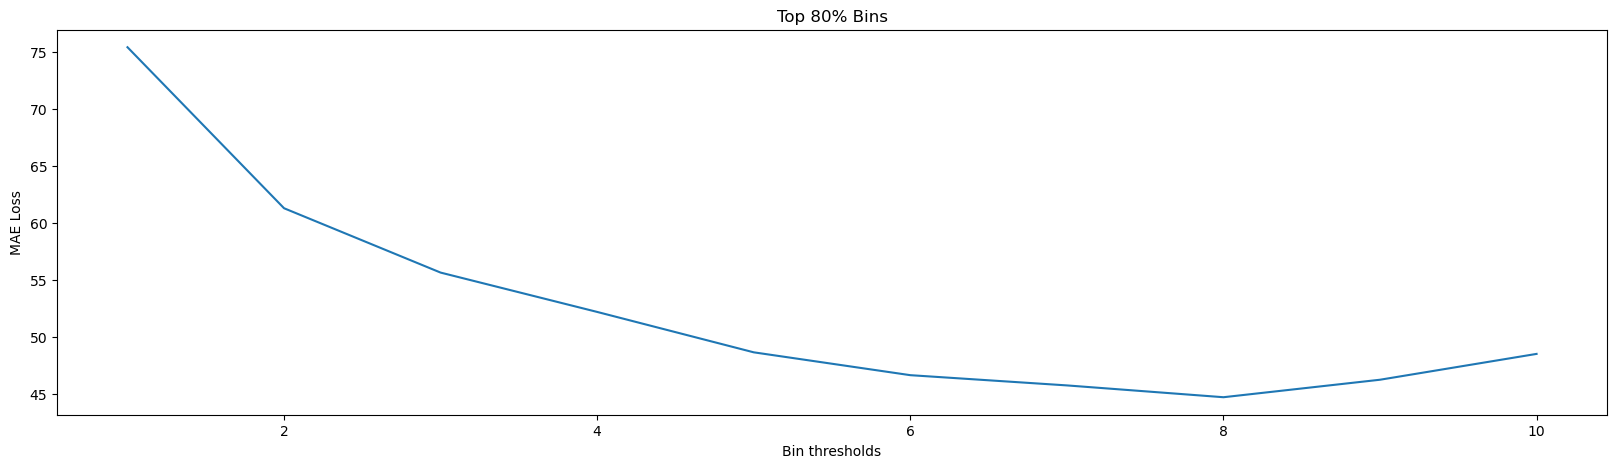

tensor(50.7724) [tensor(84.7537), tensor(70.4918), tensor(64.5643), tensor(61.9361), tensor(58.3488), tensor(57.0519), tensor(54.9555), tensor(50.7724), tensor(51.1513), tensor(52.6599)]


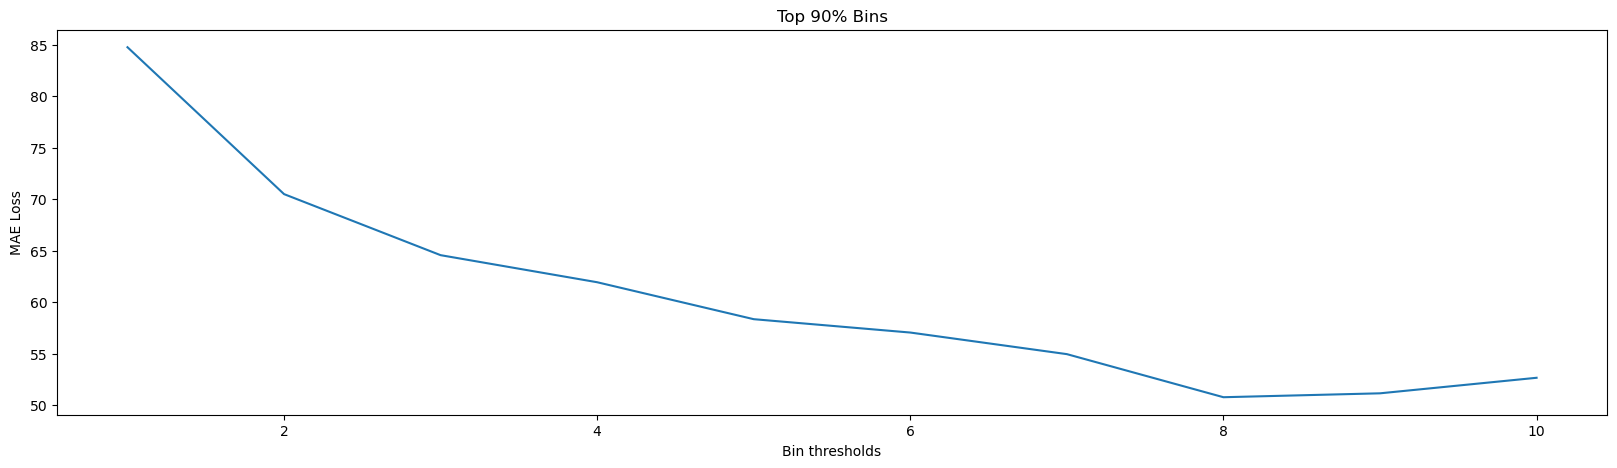

tensor(57.9730) [tensor(93.8617), tensor(78.8553), tensor(75.8034), tensor(72.1894), tensor(68.6966), tensor(66.5691), tensor(64.6035), tensor(59.0628), tensor(57.9730), tensor(58.8571)]


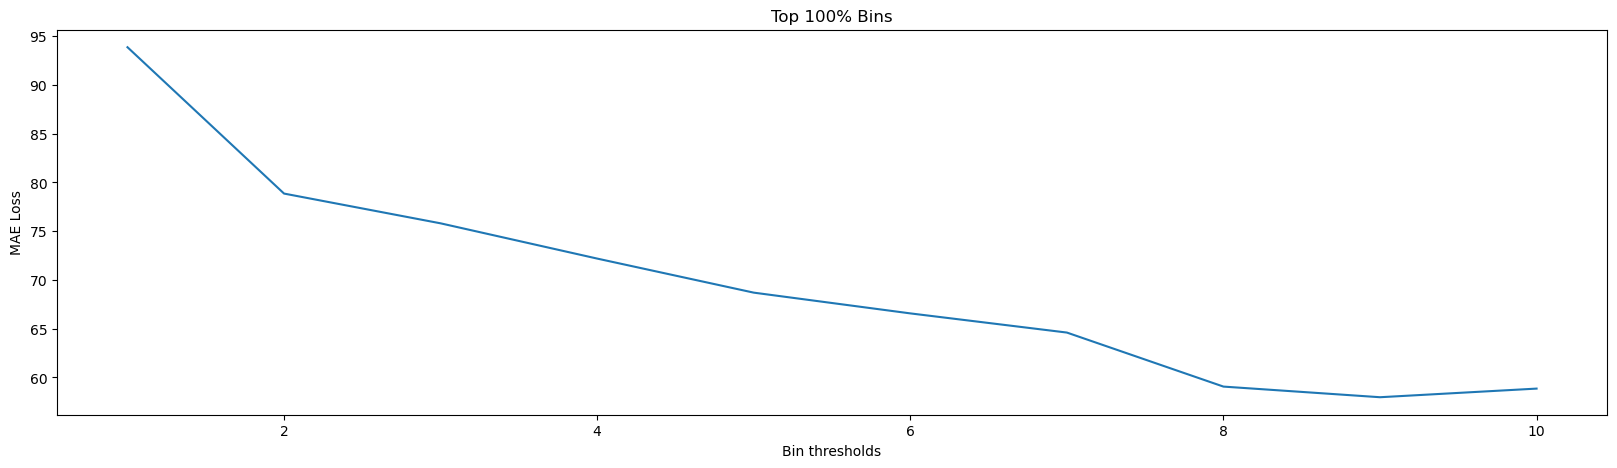

In [23]:
for j in range(20):
    plt.plot([i for i in range(1,11)], [test_results[i][j] for i in range(10)])
    print(min([test_results[i][j] for i in range(10)]), [test_results[i][j] for i in range(10)])
    if j < 10:
        plt.title(f"Bin {j+1}")
        plt.xlabel("Bin")
        plt.ylabel("MAE Loss")

    else:
        plt.title(f"Top {j-10+1}0% Bins")
        plt.xlabel("Bin thresholds")
        plt.ylabel("MAE Loss")
    plt.show()

# Graphs of RMS and node positions

In [6]:
def indexes_by_min_rms(rms_waves, min_rms):
    rms_waves_min_values, _ = rms_waves.reshape(-1, 16).max(axis=1)
    indexes = torch.nonzero(rms_waves_min_values >= min_rms).reshape(-1)
    return indexes

def calculate_rms(waveforms, axis=2):
    return torch.sqrt(torch.mean(waveforms ** 2, axis=axis))

def has_min_rms(waveforms, min_rms=0.0035):
    rms = calculate_rms(waveforms, axis=2)
    if torch.max(rms) < min_rms:
        return False
    else:
        return True

def test_rms_vals(waveforms, positions, rms_value):    
    node_positions = torch.tensor([[610, 199], [233, 13], [13, 117], [491, 393]]).cuda()

    node_1_distance = torch.sqrt(((positions - node_positions[0]) ** 2).sum(axis=1))
    node_2_distance = torch.sqrt(((positions - node_positions[1]) ** 2).sum(axis=1))
    node_3_distance = torch.sqrt(((positions - node_positions[2]) ** 2).sum(axis=1))
    node_4_distance = torch.sqrt(((positions - node_positions[3]) ** 2).sum(axis=1))
    node_distances = torch.vstack([node_1_distance, node_2_distance, node_3_distance, node_4_distance]).T
    rms_waves=calculate_rms(waveforms, axis=3)
    figure, axis = plt.subplots(1, 4)
    # a = [0.0055, 0.0050, 0.0047, 0.0044, 0.0042, 0.0040, 0.0038, 0.0033, 0.0028, 0.0021]
    # a.reverse()
    # for rms_value in a:
    filtered_indexes = indexes_by_min_rms(rms_waves, rms_value)
    node = 1
    channel = 1
    print(node_distances[:, node].shape, rms_waves[:, node, channel].shape)
    print("After filtering", len(filtered_indexes))
    plt.rcParams['figure.figsize'] = [20, 5]

    for node in range(4):
        axis[node].set_title(f"Node %i: Channel: %i Filtered at %s" % (node + 1, channel, str(rms_value)))
        axis[node].set_ylim((0.001, 0.009))
        axis[node].set_xlabel("Distance from Node (cm)")
        axis[node].set_ylabel("RMS")
        axis[node].scatter(node_distances[:, node].cpu(), rms_waves[:, node, channel].cpu(), s=5, label="Removed Data Points")
        axis[node].scatter(node_distances[:, node][filtered_indexes].cpu(), rms_waves[:, node, channel][filtered_indexes].cpu(), s=5, label="Remaining Data Points")
        # axis[channel].scatter(node_distances[:, node][indexes].cpu(), rms_waves[:, node, channel][indexes].cpu(), s=5)
        axis[node].legend()
    plt.show()

torch.Size([5764]) torch.Size([5764])
After filtering 3953


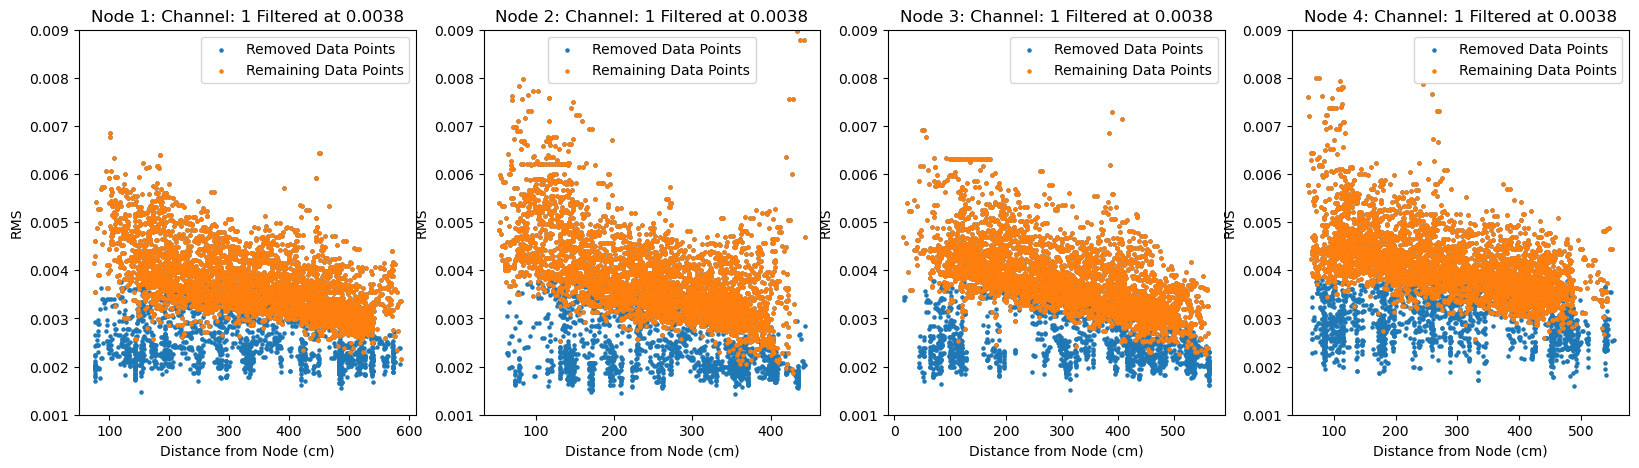

In [14]:
plt.rcParams['figure.figsize'] = [20, 5]
test_rms_vals(combined_waveforms.cuda(), combined_positions.cuda(), 0.0038)
